# スクリーン株価（日足）

In [1]:
import sys
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

try:
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    from pathlib import Path
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '..'))

from funcs.technical import psar

In [2]:
symbol = '7735.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-05 00:00:00+09:00,9518.282454,9735.978902,9441.099167,9474.743164,2317200,0.0,0.0
2024-09-06 00:00:00+09:00,9514.324577,9664.733036,9242.204009,9598.434570,2779700,0.0,0.0
2024-09-09 00:00:00+09:00,9153.145824,9553.905182,9017.580313,9468.805664,2528800,0.0,0.0
2024-09-10 00:00:00+09:00,9521.250602,9885.397372,9403.496619,9782.486328,2589100,0.0,0.0
2024-09-11 00:00:00+09:00,9737.958109,10018.984438,9374.800846,9548.958008,2992100,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-27 00:00:00+09:00,11315.000000,11515.000000,11210.000000,11445.000000,1641000,0.0,0.0
2025-02-28 00:00:00+09:00,11100.000000,11195.000000,10530.000000,10670.000000,2042200,0.0,0.0
2025-03-03 00:00:00+09:00,10815.000000,10910.000000,10560.000000,10660.000000,1431300,0.0,0.0


## 日足チャートとパラボリック SAR

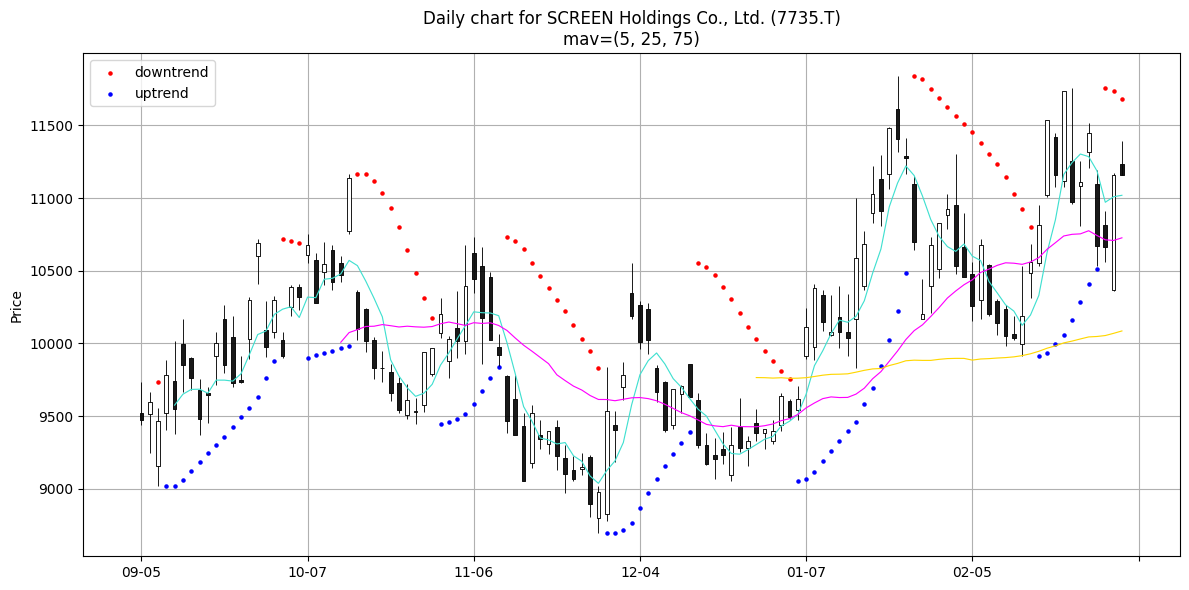

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_7735.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2025-03-04 00:00:00+09:00    11160.0
2025-03-05 00:00:00+09:00    11160.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-03-04 00:00:00+09:00    NaN
2025-03-05 00:00:00+09:00    0.0
Name: Close, dtype: float64